In [2]:
#from qutip import *
import numpy as np
import scipy as sp
import math
import matplotlib.pyplot as plt
from scipy.special import genlaguerre as L
from scipy.integrate import solve_ivp as solve
from scipy.integrate import odeint
import time

In [15]:
hbar = sp.constants.hbar
h = sp.constants.h
c = sp.constants.c
e = sp.constants.e
eVtoJ = 1.602176634e-19
amutokg = 1.66053906660e-27

omega = 2.0*np.pi*778e3 #Lange
Omegarf = 2.0*np.pi*13e6 #Lange
m = 170.936331517*amutokg
beta = 0.0
alpha = 5.89e-40 #J m^2 V^-2 E2 transition (Lange)
nu0 = 688358979309307.82 #Hz E2 transition (Huntemann)

In [4]:
def prob(n,nbar):
    return 1.0/(nbar+1)*(nbar/(nbar+1))**n    #returns prob of being in state n given nbar

def dopAndStark(n):       #for 1D!! to make 3d, multiply this by 3                        
    return -2.0*np.pi*nu0*hbar*omega*(n+0.5)/(m*c**2)*(1.0 + alpha*m**2*Omegarf**2*c**2/(h*nu0*e**2*2)) 

def Omega(n,m,eta):
    return np.abs(np.exp(-eta**2/2.0) * eta**(np.abs(m)) * (math.factorial(n)/math.factorial(n+m))**(np.sign(m)/2.0) \
        * L(n,np.abs(m))(eta**2))             #returns unitless rabi rate of transition n -> n+m given Lamb-Dicke Parameter

def fastOmega(n,m,eta):
    return 1.0 - eta**2.0*n

eta = 0.05
omegas = np.zeros(2000)
for ii in range(np.size(omegas)):
    omegas[ii] = Omega(ii,0,eta)

D:\Mark\Python\lib\site-packages\scipy\special\_orthogonal.py:651: RuntimeWarning: invalid value encountered in double_scalars
  hn = _gam(n + alpha + 1) / _gam(n + 1)
D:\Mark\Python\lib\site-packages\scipy\special\_orthogonal.py:140: RuntimeWarning: invalid value encountered in multiply
  np.poly1d.__init__(self, poly.coeffs * float(kn))
D:\Mark\Python\lib\site-packages\scipy\special\_orthogonal.py:196: RuntimeWarning: overflow encountered in true_divide
  w = 1.0 / (fm * dy)
D:\Mark\Python\lib\site-packages\scipy\special\_orthogonal.py:202: RuntimeWarning: invalid value encountered in multiply
  w *= mu0 / w.sum()
D:\Mark\Python\lib\site-packages\scipy\special\_orthogonal.py:127: RuntimeWarning: invalid value encountered in double_scalars
  equiv_weights = [weights[k] / wfunc(roots[k]) for
D:\Mark\Python\lib\site-packages\scipy\special\_orthogonal.py:196: RuntimeWarning: divide by zero encountered in true_divide
  w = 1.0 / (fm * dy)
D:\Mark\Python\lib\site-packages\scipy\special\_or

In [5]:
#takes rho as a 3 element vector and converts it to a 2x2 matrix by calculating the conj. of rhoge
def subpulse(rho0, t, Omega0, delta):
    rho = np.array([[rho0[0], rho0[2]],[np.conj(rho0[2]), rho0[1]]])
    Omega = np.sqrt(Omega0**2 + delta**2)
    if Omega == 0.0:
        U = np.array([[1.0 , 0.0],
                      [0.0 , 1.0]])
    else:
        U = np.array([[np.cos(Omega*t/2.0) -(1.0j*delta/Omega)*np.sin(Omega*t/2.0), (1.0j*Omega0/Omega)*np.sin(Omega*t/2.0)],
                     [(1.0j*Omega0/Omega)*np.sin(Omega*t/2.0) , np.cos(Omega*t/2.0) + (1.0j*delta/Omega)*np.sin(Omega*t/2.0)]])
    rho = U@rho@np.conj(U)
    return np.array([rho[0,0], rho[1,1], rho[0,1]])

def pulse(rho0, t, Omega0, delta):
    Ncut = rho0.size//3 - 1
    rho = np.array([0.0+0.0j]*3*(Ncut+1))
    for n in range(Ncut):
        rho[3*n:3*(n+1)] = subpulse(rho0[3*n:3*(n+1)], t, Omega0*omegas[n], delta)
    return rho

In [6]:
def heatEqns(t, rho, nbardot):
    Ncut = rho.shape[0]//3 - 1
    rhoDot = [0.0+0.0j]*((Ncut+1)*3)
    for ii in range(3):
        rhoDot[0+ii] = nbardot*(-rho[0+ii]+rho[3*1+ii])
        rhoDot[3*Ncut+ii] = nbardot*(-Ncut*rho[3*Ncut+ii]+Ncut*rho[3*(Ncut-1)+ii])
        #Note*** the above line is true in the limit that rho[Ncut+1,ii]=rho[Ncut,ii] (fair assumption for large Ncut I think)
        for n in range(1,Ncut-1):
            rhoDot[3*n+ii] = nbardot*(-(2.0*n+1.0)*rho[3*n+ii] + (n+1.0)*rho[3*(n+1)+ii] + n*rho[3*(n-1)+ii])
    return rhoDot

def heat(rho0, t, nbardot):
    rho = solve(heatEqns, [0.0,t], rho0, args=[nbardot]).y[:,-1]
    return rho

def fastHeat(rho0, t, nbardot, Nstop):
    #Nstop = 100
    Ncut = rho0.shape[0]//3 - 1
    rho = np.array([0.0+0.0j]*3*(Ncut+1))
    rho[:3*Nstop] = solve(heatEqns, [0.0,t], rho0[:3*Nstop], args=[nbardot]).y[:,-1]
    rho[3*Nstop:] = rho0[3*Nstop:]
    return rho

In [7]:
def subFreeEvo(rho0, phi):
    return np.array([rho0[0], rho0[1], rho0[2]*np.exp(-1.0j*phi)])

def freeEvo(rho0, phi):
    Ncut = rho0.size//3 - 1
    rho = np.array([0.0+0.0j]*3*(Ncut+1))
    for n in range(Ncut):
        rho[3*n:3*(n+1)] = subFreeEvo(rho0[3*n:3*(n+1)], phi)
    return rho

In [8]:
def groundRho(Ncut, nbar):
    rho = np.array([0.0+0.0j]*3*(Ncut+1))
    for n in range(Ncut):
        rho[3*n] = prob(n,nbar)
    return rho

def nbar(rho):
    Ncut = rho.shape[0]//3
    nbar = 0.0
    for n in range(Ncut):
        nbar += n*(rho[n*3].real + rho[n*3+1].real)
    return nbar

def rhogg(rho):
    rhogg = 0.0
    Ncut = rho.shape[0]//3
    for n in range(Ncut):
        rhogg += rho[(3*n)].real
    return rhogg

def rhoee(rho):
    rhoee = 0.0
    Ncut = rho.shape[0]//3
    for n in range(Ncut):
        rhoee += rho[(3*n)+1].real
    return rhoee

In [29]:
def ramsey(rho0, t1, T, t2, deld, delPrime, Omega0):
    intState = freeEvo(pulse(rho0, t1, Omega0, delPrime), deld*T)
    result = pulse(intState, t2, Omega0, delPrime)
    return result

def RamseyErrSig(deld, rho0, t1, T, t2, delPrime, Omega0):
    intState = freeEvo(pulse(rho0, t1, Omega0, delPrime), deld*T)
    resultP = pulse(freeEvo(intState, np.pi/2.0), t2, Omega0, delPrime)
    resultM = pulse(freeEvo(intState, -np.pi/2.0), t2, Omega0, delPrime)                   
    return rhoee(resultP) - rhoee(resultM)

def HRSJumpErrSig(deld, rho0, t1, T, t2, delPrime, Omega0):
    intState = freeEvo(pulse(rho0, t1, Omega0, delPrime), deld*T)
    resultP = pulse(pulse(freeEvo(intState,np.pi/2.0),2.0*t2/3.0,-Omega0,delPrime),t2/3.0,Omega0,delPrime)
    resultM = pulse(pulse(freeEvo(intState,-np.pi/2.0),2.0*t2/3.0,-Omega0,delPrime),t2/3.0,Omega0,delPrime)
    return rhoee(resultP) - rhoee(resultM)

def heatRSErrSig(deld, rho0, t1, T, t2, delPrime, Omega0, nbardot):
    Nstop1 = 100
    ni = nbar(rho0)
    nDarkTimeAvg = ni+nbardot*(2.0*t1+T)/2.0 #avg nbar during the dark time, gives us the phase accum
    intState = freeEvo(fastHeat(pulse(rho0, t1, Omega0, delPrime+dopAndStark(ni)), t1, nbardot, Nstop1), (deld+dopAndStark(nDarkTimeAvg))*T)
    Nstop2 = 350
    instState = fastHeat(intState, T, nbardot, Nstop2)
    n = nbardot*(t1+T)
    resultP = pulse(freeEvo(intState, np.pi/2.0), t2, Omega0, delPrime+dopAndStark(n))
    resultM = pulse(freeEvo(intState, -np.pi/2.0), t2, Omega0, delPrime+dopAndStark(n))
    return rhoee(resultP) - rhoee(resultM)

In [33]:
pts = 5
nbarfs = np.linspace(0,30,pts)
shifts = np.zeros(pts)
rho0 = groundRho(1000,0.0)
t1 = 20.0e-3
t2 = 3.0*t1
T = 200.0e-3
delPrime = 10.0e-3*2.0*np.pi
Omega0 = np.pi/(2.0*t1)

tol = 1.0e-6
x0 = -0.001
x1 = 0.001
guessTol = 0.001

for ii in range(pts):
    print("nbarf = ", nbarfs[ii])
    nbardot = nbarfs[ii]/(t1+T+t2)
    start = time.time()
    shifts[ii] = sp.optimize.root_scalar(heatRSErrSig, args=(rho0, t1, T, t2, delPrime, Omega0, nbardot), bracket=[x0,x1], xtol = tol).root
    end = time.time()
    print("time = ", end-start)
    print("shift = ", shifts[ii]/(2.0*np.pi))
    x0 = shifts[ii] - guessTol
    x1 = shifts[ii] + guessTol
    print("bracket = ", x0,x1)

nbarf =  0.0
time =  1.1320626735687256
shift =  5.003978330588518e-06
bracket =  -0.0009685590768758012 0.0010314409231241988
nbarf =  7.5
time =  204.28036785125732
shift =  -1.7650254988335132e-06
bracket =  -0.001011089982281068 0.000988910017718932
nbarf =  15.0
time =  452.693071603775
shift =  -8.647220094343838e-06
bracket =  -0.0010543320862447293 0.0009456679137552707
nbarf =  22.5
time =  689.2560920715332
shift =  -1.56453416164386e-05
bracket =  -0.0010983025805702124 0.0009016974194297877
nbarf =  30.0
time =  911.2118360996246
shift =  -2.276417644144634e-05
bracket =  -0.0011430315389469392 0.0008569684610530607


array([ 3.14409231e-05, -1.10899823e-05, -5.43320862e-05, -9.83025806e-05,
       -1.43031539e-04])

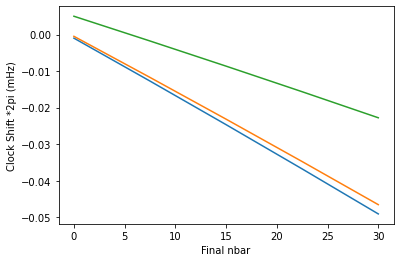

In [32]:
shifts1 = np.array([-6.20680991e-06, -7.99737963e-05, -1.54891781e-04, -2.30985123e-04,
       -3.08277711e-04])
shifts2 = np.array([-3.05706389e-06, -7.37004742e-05, -1.45450904e-04, -2.18331994e-04,
       -2.92368253e-04])
plt.plot(nbarfs, 1e3*shifts1/(2.0*np.pi))
plt.plot(nbarfs, 1e3*shifts2/(2.0*np.pi))
plt.plot(nbarfs, 1e3*shifts/(2.0*np.pi))

plt.xlabel("Final nbar")
plt.ylabel("Clock Shift *2pi (mHz)")
shifts

In [146]:
rho0 = groundRho(1000,0.0)
t1 = 20.0e-3
t2 = 3.0*t1
T = 200.0e-3
delPrime = 0.0
deld = 0.001*2.0*np.pi
Omega0 = np.pi/(2.0*t1)
nbardot = 100.0

hbar = sp.constants.hbar
h = sp.constants.h
c = sp.constants.c
e = sp.constants.e
eVtoJ = 1.602176634e-19
amutokg = 1.66053906660e-27

omega = 2.0*np.pi*778e3 #Lange
Omegarf = 2.0*np.pi*13e6 #Lange
m = 170.936331517*amutokg
beta = 0.0
alpha = 5.89e-40 #J m^2 V^-2 E2 transition (Lange)
nu0 = 688358979309307.82 #Hz E2 transition (Huntemann)

start = time.time()
rho = heatRSErrSig(deld, rho0, t1, T, t2, delPrime, Omega0, nbardot)
end = time.time()
print(end-start)

97.36489152908325


In [11]:
rho0 = groundRho(1000,0.0)
t1 = 20.0e-3
t2 = 3.0*t1
T = 200.0e-3
delPrime = 0.0
deld = 0.001*2.0*np.pi
Omega0 = np.pi/(2.0*t1)
nbardot = 100.0

hbar = sp.constants.hbar
h = sp.constants.h
c = sp.constants.c
e = sp.constants.e
eVtoJ = 1.602176634e-19
amutokg = 1.66053906660e-27

omega = 2.0*np.pi*778e3 #Lange
Omegarf = 2.0*np.pi*13e6 #Lange
m = 170.936331517*amutokg
beta = 0.0
alpha = 5.89e-40 #J m^2 V^-2 E2 transition (Lange)
nu0 = 688358979309307.82 #Hz E2 transition (Huntemann)

start = time.time()
rho = RamseyErrSig(deld, rho0, t1, T, t2, delPrime, Omega0)
end = time.time()
print(end-start)

0.2127974033355713


In [87]:
rho0 = groundRho(1000, 0.0)
start = time.time()
Nbar = nbar(fastHeat(rho0, 1.0, 1.0, Nstops[ii]))
end = time.time()
print(end-start)

0.9831652641296387


In [136]:
#Nstops = np.array([20, 50, 75, 100, 200, 300, 400, 600, 800, 900])
Nstops = np.linspace(10, 510, 21)
pts = np.size(Nstops)
times = np.zeros(pts)
errs = np.zeros(pts)
rho0 = groundRho(1000, 2.0)
for ii in range(pts):
    start = time.time()
    Nbar = nbar(fastHeat(rho0, 200.0e-3, 100.0, int(Nstops[ii])))
    end = time.time()
    times[ii] = end-start
    print(times[ii])
    errs[ii] = 100*(Nbar-22.0)/22.0

0.04690670967102051
0.6652235984802246
1.983659029006958
3.8427534103393555
6.496585845947266
9.967365741729736
13.90882682800293
18.573313236236572
26.80643391609192
35.51911187171936
43.187761545181274
54.35204219818115
63.88924765586853
74.56935906410217
87.18542981147766
99.41947841644287
114.7118661403656
125.03819584846497
143.4250967502594
160.12489438056946
174.5672104358673


array([-9.60801684e+01, -7.37184996e+01, -3.96055057e+01, -1.83025475e+01,
       -7.79095337e+00, -3.15161625e+00, -1.23186142e+00, -4.70014428e-01,
       -1.76335403e-01, -6.52344590e-02, -2.44361233e-02, -8.63928689e-03,
       -3.26129363e-03, -1.57276575e-03, -8.51464869e-04, -2.48475292e-04,
       -4.31005313e-04, -1.92180118e-04, -2.99642522e-04, -3.29657480e-04,
       -6.80499795e-04])

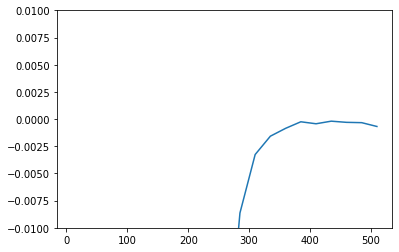

In [138]:
plt.plot(Nstops, errs)
plt.ylim([-0.01, 0.01])
errs

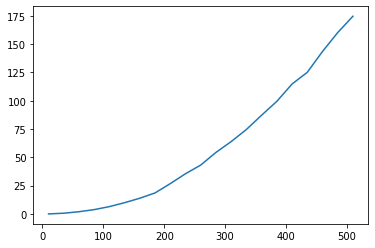

In [140]:
plt.plot(Nstops, times)

In [20]:
t1 = 20e-3
t2 = 3.0*t1
Omega0 = np.pi/(2.0*t1) #hz
T = 200e-3
rho0 = groundRho(1000, 0.0)
#rho0 = heat(groundRho(1000, 0.0), 1.0, 1.0)

pts = 30
delPrimes = np.linspace(0, 0.1*2.0*np.pi, pts)
deltas = np.zeros(pts)
guessTol = 0.1
x0 = -0.1
x1 = 0.1

start = time.time()
for ii in range(pts):
    print(x0,x1)
    deltas[ii] = sp.optimize.root_scalar(RamseyErrSig, args=(rho0, t1, T, t2, delPrimes[ii], Omega0), bracket=[x0,x1], xtol = 1e-5).root
    x0 = deltas[ii] - guessTol
    x1 = deltas[ii] + guessTol
    print(deltas[ii])

end = time.time()
print("time= ",end-start)

-0.1 0.1
0.0
-0.1 0.1
1.0859438753743622e-05
-0.09998914056124626 0.10001085943875375
2.171832692104969e-05
-0.09997828167307896 0.10002171832692106
3.257321792482504e-05
-0.09996742678207518 0.10003257321792483
4.342211277721941e-05
-0.09995657788722279 0.10004342211277722
5.426301270944345e-05
-0.09994573698729056 0.10005426301270945
6.509391898365524e-05
-0.09993490608101635 0.10006509391898366
7.591283289971884e-05
-0.09992408716710029 0.10007591283289972
8.67177558047244e-05
-0.09991328224419528 0.10008671775580473
9.750668910063487e-05
-0.09990249331089937 0.10009750668910064
0.00010827763425050319
-0.0998917223657495 0.10010827763425051
0.00011902859278847822
-0.09988097140721153 0.10011902859278848
0.00012975756632521707
-0.09987024243367479 0.10012975756632522
0.00014046255655777995
-0.09985953744344223 0.10014046255655779
0.0001511415652757364
-0.09984885843472427 0.10015114156527574
0.00016179259437033855
-0.09983820740562967 0.10016179259437034
0.00017241364584109908
-0.099

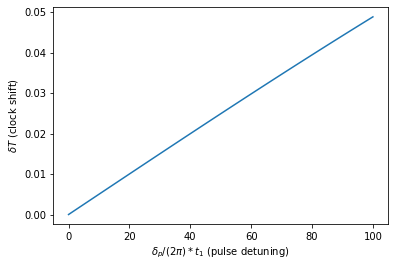

In [21]:
plt.plot(delPrimes*1e3/(2.0*np.pi), deltas*1e3/(2.0*np.pi))
plt.xlabel(r"$\delta_p/(2\pi)*t_1$ (pulse detuning)" )
plt.ylabel(r"$\delta T$ (clock shift)")
plt.show()

In [40]:
start = time.time()
print(nbar(heat(groundRho(1000,0.0), 0.05, 100.0)))
end = time.time()
print(end-start)

5.000095956640908
126.15862822532654


In [60]:
start = time.time()
print(nbar(heat(groundRho(1000,0.0), 1.0, 1.0)))
end = time.time()
print(end-start)

1.0000000000000007
0.9870343208312988


In [66]:
start = time.time()
print(nbar(fastHeat(groundRho(2000,0.0), 1.0, 1.0)))
end = time.time()
print(end-start)

0.9999793117474755
0.10674786567687988
